# The Shart Attack Problem: The Poisson Model

- Gamma-Poisson Conjugate
    - Gamma is a conjugate prior distribution for Poisson distribution

- Poisson Distribution:

$$
    Pr[X=k | \lambda] = e^{-\lambda}\frac{\lambda^k}{k!}
$$

In [1]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import jax
import jax.random as random
import jax.numpy as jnp
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;
#sns.set_style("darkgrid");
plt.rcParams['figure.dpi'] = 100
# plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.style.use("dark_background")

In [2]:
def medstat(v):
    v = v.sort()
    med = v[len(v)//2]
    mad = np.median(np.abs(v-med))
    mad_sd = 1.483 * mad
    return med, mad_sd

def print_abs_summary(d, keys=None):
    print(' Med MAD_SD')
    for k, v in d.items():
        if (keys is None) or (k in keys):
            med, mad_sd = medstat(v)
            print(f'{k:7} {med:+5.3f} {mad_sd:+5.3f}')

In [3]:
rngkey = random.PRNGKey(0)
rngkey, subkey = jax.random.split(rngkey)
rngkey

array([4146024105,  967050713], dtype=uint32)

In [4]:
df = pd.DataFrame( {'year': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'attacks': [1, 0, 2, 1, 1, 3, 2, 3, 4, 4]})
df

,year,attacks
0,1,1
1,2,0
2,3,2
3,4,1
4,5,1
5,6,3
6,7,2
7,8,3
8,9,4
9,10,4


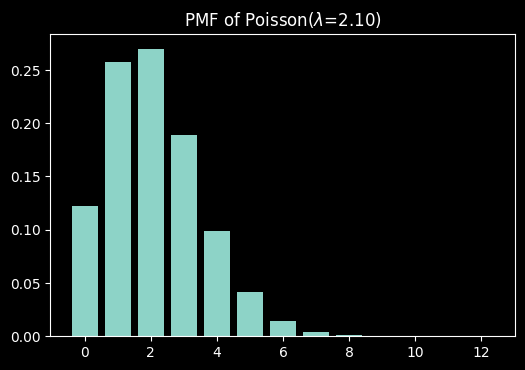

In [5]:
mean = df.attacks.mean() # average attacks per year
poi = stats.poisson(mu=mean)
x = np.arange(0, 13)
pmf = poi.pmf(x)
plt.bar(x, pmf);
plt.title(f'PMF of Poisson($\\lambda$={mean:.2f})');

# Poisson distribution with $\lambda$

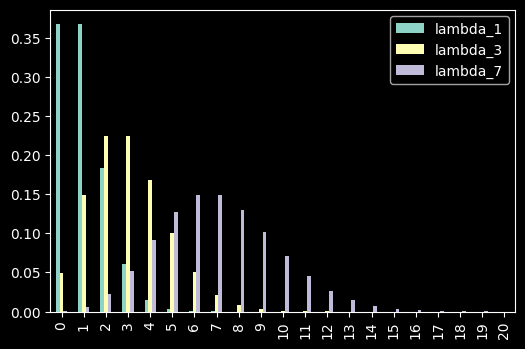

In [6]:
d = {}
x = np.arange(0, 21)
for m in [1, 3, 7]:
    poi = stats.poisson(mu=m)
    pmf = poi.pmf(x)
    d[f'lambda_{m}'] = pmf
dfpoi = pd.DataFrame(d, index=x)
dfpoi.plot(kind='bar');

In [7]:
mean = df.attacks.mean() # average attacks per year
poi = stats.poisson(mu=mean)
samples = poi.rvs(size=100)
samples

array([3, 2, 5, 1, 2, 2, 0, 0, 0, 1, 2, 4, 2, 3, 3, 4, 3, 2, 1, 1, 2, 6,
       0, 3, 1, 3, 2, 5, 3, 2, 3, 0, 4, 2, 0, 3, 3, 2, 2, 4, 0, 1, 4, 0,
       2, 2, 2, 3, 1, 1, 2, 4, 2, 2, 3, 3, 3, 1, 0, 4, 0, 2, 3, 4, 2, 2,
       3, 1, 4, 3, 5, 2, 6, 0, 1, 4, 3, 2, 3, 4, 4, 4, 1, 3, 2, 2, 2, 5,
       1, 1, 2, 0, 2, 1, 1, 3, 0, 1, 1, 2])

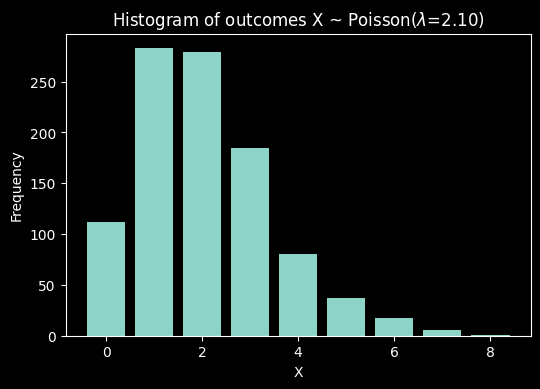

In [8]:
u, c = np.unique(poi.rvs(size=1000), return_counts=True)
plt.bar(u, c);
plt.ylabel('Frequency'); plt.xlabel('X')
plt.title(f'Histogram of outcomes X ~ Poisson($\\lambda$={mean:.2f})');

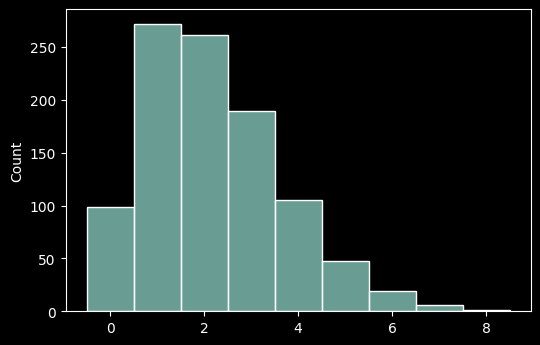

In [14]:
sns.histplot(poi.rvs(size=1000), discrete=True);

# Bayesian Inferenc on $\lambda$

## Prior Models

- log-Normal

$$
    X \sim Normal(0,1) \\
    Y = e^{X}  \quad\Leftrightarrow\quad Y \sim \mathrm{LogNormal}(0, 1)
$$

- Exponential

$$
    X \sim \mathrm{Exp}(\lambda)
$$

- Gamma

$$
    X \sim \mathrm{Gamma}(a, b)
$$

- Uniform



## Log-Normal

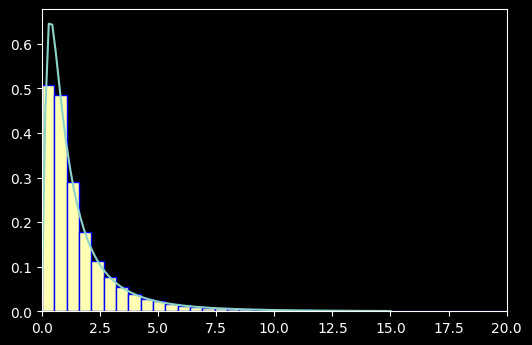

In [15]:
# Log-Normal from Math
x = np.linspace(0, 15, 100)
pdf = stats.lognorm(s=1, loc=0, scale=1.).pdf(x)
plt.plot(x, pdf);
plt.xlim([0, 20])
# log-normal from exp(Normal)
Xsamples = stats.norm(loc=0, scale=1).rvs(100000)
Ysamples = np.exp(Xsamples)
plt.hist(Ysamples, density=True, edgecolor='b', bins=200); # <-- increase size of bin

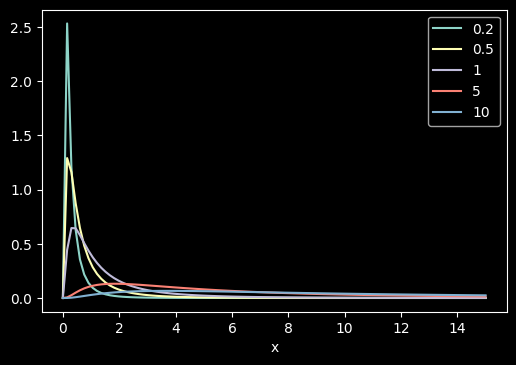

In [17]:
# Log-Normal from Math
x = np.linspace(0, 15, 100)
pdfs = {}
for scale in [0.2, 0.5, 1, 5, 10]:
    pdf = stats.lognorm(s=1, loc=0, scale=scale).pdf(x)
    pdfs[scale] = pdf
#
pdfs['x'] = x
dfpdfs = pd.DataFrame(pdfs)
dfpdfs.plot(x='x');

## Gamma

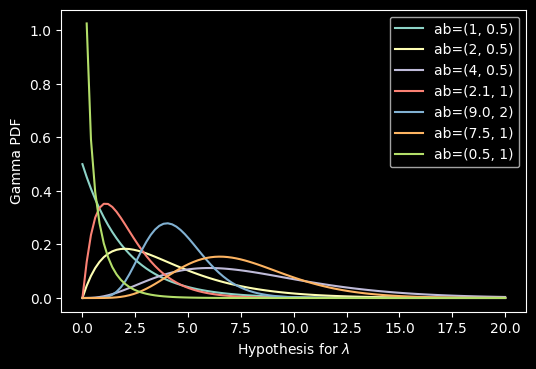

In [18]:
# Gamma distributions
# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html#scip
params = [(1, .5), (2, .5), (4, .5), (2.1, 1), (9.0, 2), (7.5, 1), (.5, 1)]
x = np.linspace(0, 20, 100)
d = {}
for ab in params:
    a, b = ab
    scale = 1. / b
    gamma = stats.gamma(a=a, scale=scale)
    pdf = gamma.pdf(x)
    d[f'ab={ab}'] = pdf
d['x'] = x
a = pd.DataFrame(d).plot(x='x');
a.set(xlabel='Hypothesis for $\\lambda$', ylabel='Gamma PDF');

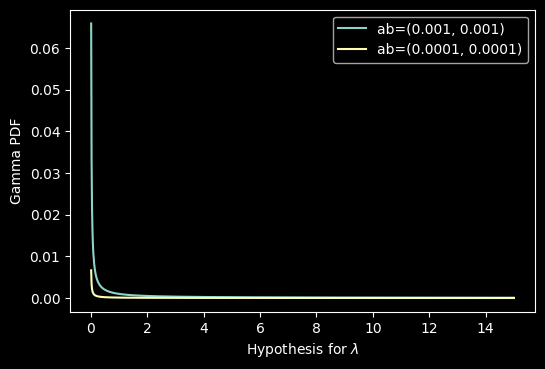

In [20]:
# Gamma distributions as Vague Prior
# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html#scip
params = [(.001, .001), (.0001, .0001)]
x = np.linspace(0, 15, 1000)
d = {}
for ab in params:
    a, b = ab
    scale = 1. / b
    gamma = stats.gamma(a=a, scale=scale)
    pdf = gamma.pdf(x)
    d[f'ab={ab}'] = pdf
d['x'] = x
a = pd.DataFrame(d).plot(x='x');
a.set(xlabel='Hypothesis for $\\lambda$', ylabel='Gamma PDF');

## Inference with Poisson-Gamma Conjugate

$$
p(λ|data) = Gamma(ap, bp) \\
ap = a + \sum_i data[i] \\
bp = b + n(data) \\
scale = 1/bp
$$

1. Start with a vague prior
2. update for new data is easy
    - Yesterday's posterior is today's prior

## Numpyro Inference

In [21]:
def mcmcinf(model, args):
    # args: dict for model input arguments
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=10000, num_chains=1)
    #
    mcmc.run(rngkey, **args)
    mcmc.print_summary(exclude_deterministic=True, prob=.8)
    return mcmc

In [22]:
def model(data, scale=1.):
    lamb = numpyro.sample('lambda', dist.LogNormal(loc=0., scale=scale))
    with numpyro.plate('plate', size=len(data)):
        obs = numpyro.sample('obs', dist.Poisson(lamb), obs=data)
#
def model_u(data):
    lamb = numpyro.sample('lambda', dist.Uniform(low=0., high=7))
    with numpyro.plate('plate', size=len(data)):
        obs = numpyro.sample('obs', dist.Poisson(lamb), obs=data)
#
def model_gamma(data, a=0.001, b=0.001):
    lamb = numpyro.sample('lambda', dist.Gamma(concentration=a, rate=b))
    with numpyro.plate('plate', size=len(data)):
        obs = numpyro.sample('obs', dist.Poisson(lamb), obs=data)
#

In [23]:
mcmc1 = mcmcinf(model, dict(data=df.attacks.values, scale=1.))
mcmc5 = mcmcinf(model, dict(data=df.attacks.values, scale=5.))
mcmcu = mcmcinf(model_u, dict(data=df.attacks.values))
mcmcg = mcmcinf(model_gamma, dict(data=df.attacks.values, a=0.001, b=0.001))
mcmcg00001 = mcmcinf(model_gamma, dict(data=df.attacks.values, a=0.0001, b=0.00001))

  0%|          | 0/11000 [00:00<?, ?it/s]


                mean       std    median     10.0%     90.0%     n_eff     r_hat
    lambda      2.04      0.44      2.00      1.48      2.58   3430.11      1.00

Number of divergences: 0


  0%|          | 0/11000 [00:00<?, ?it/s]


                mean       std    median     10.0%     90.0%     n_eff     r_hat
    lambda      2.11      0.46      2.07      1.48      2.63   4088.68      1.00

Number of divergences: 0


  0%|          | 0/11000 [00:00<?, ?it/s]


                mean       std    median     10.0%     90.0%     n_eff     r_hat
    lambda      2.21      0.47      2.17      1.56      2.73   3116.08      1.00

Number of divergences: 0


  0%|          | 0/11000 [00:00<?, ?it/s]


                mean       std    median     10.0%     90.0%     n_eff     r_hat
    lambda      2.11      0.46      2.07      1.51      2.64   3299.15      1.00

Number of divergences: 0


sample: 100%|██████████| 11000/11000 [00:10<00:00, 1057.99it/s, 3 steps of size 1.09e+00. acc. prob=0.89]



                mean       std    median     10.0%     90.0%     n_eff     r_hat
    lambda      2.10      0.46      2.06      1.49      2.66   3953.12      1.00

Number of divergences: 0


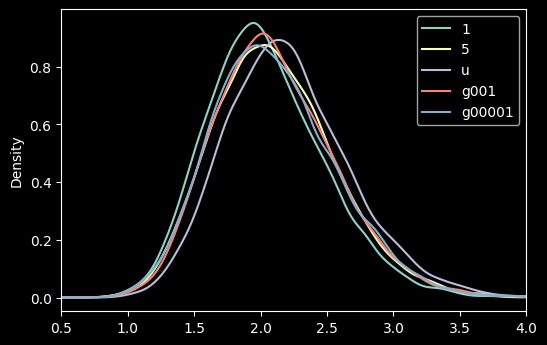

In [24]:
dmcmc = {'1': mcmc1, '5': mcmc5, 'u': mcmcu, 'g001': mcmcg, 'g00001': mcmcg00001}
dfmcmc = pd.DataFrame({k: m.get_samples()['lambda'] for k, m in dmcmc.items()})
#
ax = dfmcmc.plot(kind='kde');
ax.set(xlim=[0.5, 4]);

---

In [25]:
!jupyter nbconvert Poisson_Model_Inference.ipynb --to webpdf --HTMLExporter.theme=dark --allow-chromium-download

[NbConvertApp] Converting notebook Poisson_Model_Inference.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 336078 bytes to Poisson_Model_Inference.pdf
